# Cubical multifiltrations

This family of filtrations is well suited for "multicolor" images.

In [1]:
import multipers as mp
from multipers.data.synthetic import three_annulus
import matplotlib.pyplot as plt
from multipers.filtrations.density import KDE
import numpy as np
import gudhi as gd

We start from a large point cloud

In [2]:
np.random.seed(0)
X = three_annulus(50_000,50_000)
X /= 4
X+=.5

This point cloud is too large to be quickly dealt with, so we consider its density (estimation) on a small grid

In [3]:
resolution = [200,200]
grid = mp.grids.todense([np.linspace(0,1,r) for r in resolution])
density = KDE(bandwidth=.04, return_log=True).fit(X).score_samples(grid).reshape(resolution)

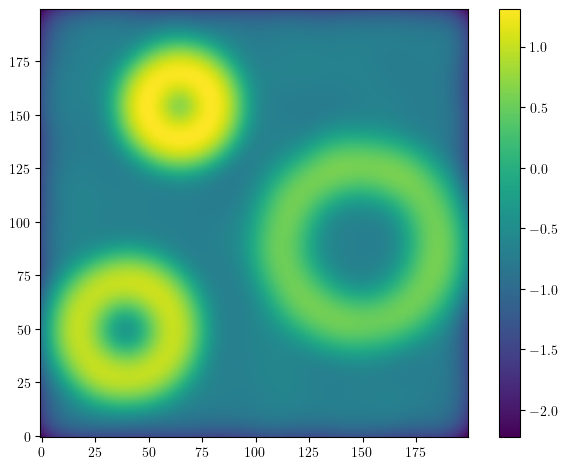

In [4]:
plt.imshow(density, origin="lower")
plt.colorbar()

Let say now that we want to recover the $x$ scale of the time of appearance of the topological features, as well as their concentration, given by a density map $f$.

We build the following filtration: a given pixel $p\in \mathbb R^2$ in the image will appear in the filtration at coordinates $(x,y)$ if 
 - $p_1\le x$ ($x$ coordinate), and
 - $f(p) \ge y$ (the pixel is dense enough).

In `multipers` the expected format to encode this filtration is an array of shape $(\mathrm{image\_resolution}\dots ,\mathrm{num\_parameters})$.
<br>
In our case, the resolution is [200,200] and we have 2 parameters, so this correspond to the following tensor.


In [5]:
bifiltration = np.empty(shape=(*resolution, 2))
bifiltration[:,:,1] = -density
R = resolution[0]
for i in range(R):
    bifiltration[:,i,0] = i/R

In [8]:
from multipers.filtrations import Cubical
s = Cubical(bifiltration)
# to make the computations faster below, we compute a minimal resolution first.
# This is *not* necessary
s = s.minpres(1)

In [9]:
mod = mp.module_approximation(s)

/tmp/ipykernel_19329/2848273690.py:1: UserWarning: (copy warning) Got a non-vine slicer as an input. Use `vineyard=True` to remove this copy.
  mod = mp.module_approximation(s)


The python object `s` now encodes our filtration! 

Let us try to recover the rank invariant from this bifiltration.
<br>
We will first fix a grid on which to compute it and project our invariant on this grid.

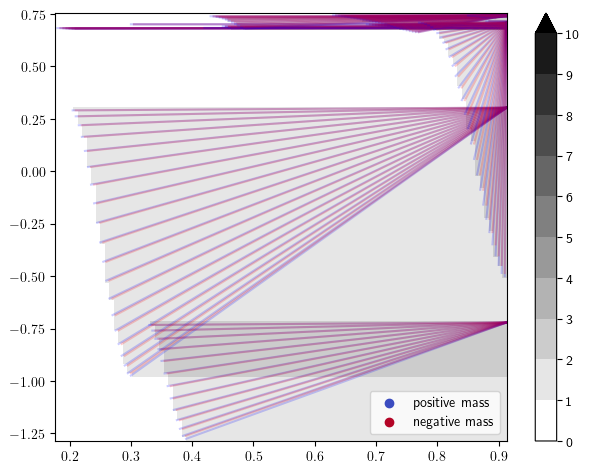

In [10]:
# hilbert decomposition signed measure 
hilbert_sm, = mp.signed_measure(s, degree=1, plot=True) 
mp.point_measure.integrate_measure(*hilbert_sm, plot=True) 

# rank decomposition signed measure
rank_sm, = mp.signed_measure(s,degree= 1, invariant = "rank");
mp.plots.plot_signed_measure(rank_sm, alpha=.2)

We indeed recover the 3 circles with the rank invariant with the 3 significant intervals.

We can also efficiently compute the barcode of line slices with the rank signed measure,
<br> 
which permits us to do [rivet](https://rivet.readthedocs.io/en/latest/#)-like visualization from multipers.

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

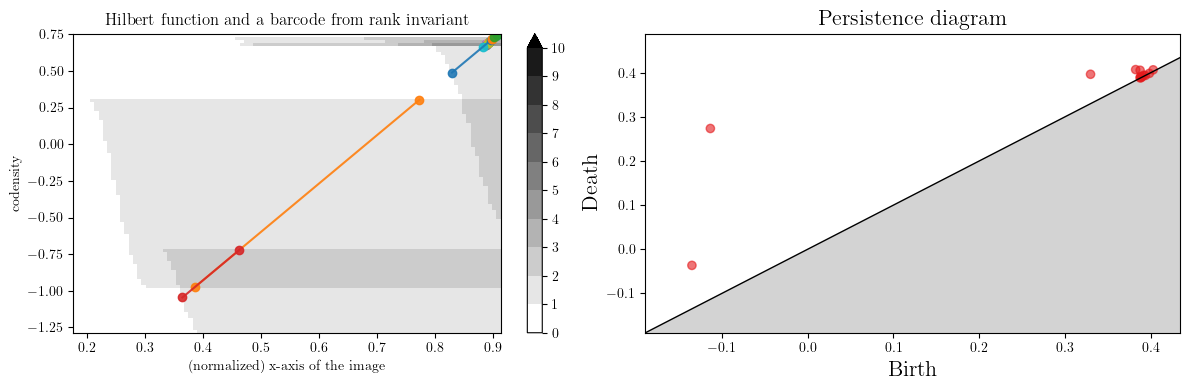

In [18]:
fig, axes = plt.subplots(nrows=1, ncols =2, figsize=(12,4))
plt.sca(axes[0])
mp.point_measure.integrate_measure(*hilbert_sm, plot=True)
basepoint = np.array([.5, -.6])
direction = np.array([1,3.3])
barcode = mp.point_measure.barcode_from_rank_sm(
    rank_sm,
    basepoint=basepoint, 
    direction=direction
)

for i,bar in enumerate(barcode):
    bar = basepoint + bar[:,None]*direction #+i*np.array([0,1])*.02 #small shift for plot
    plt.plot(bar[:,0], bar[:,1], 'o-', alpha=.9)

plt.xlabel("(normalized) x-axis of the image")
plt.ylabel("codensity")
plt.title("Hilbert function and a barcode from rank invariant")
gd.plot_persistence_diagram(barcode, axes=axes[1])

You can also directly use [rivet](https://rivet.readthedocs.io/en/latest/#) to use it interactively, but rivet is significantly slower here. 

`s` can be exported to the `firep` format:

In [19]:
s.to_scc("stuff.firep", rivet_compatible=True)

Which can then easily be imported to [rivet](https://rivet.readthedocs.io/en/latest/#).

![Rivet export](rivet_export.png)